# Imports

In [66]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import statsmodels.tsa.api as tsa
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

In [2]:
# Loading in data
OUTPUT_FOLDER = 'Data/Chicago/'
crime_files = sorted(glob.glob(OUTPUT_FOLDER+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1309918,01/01/2001 01:00:00 AM,THEFT,$500 AND UNDER,TAVERN/LIQUOR STORE,False,False,1924,19.0,NaN,41.940001,-87.654258
1,1310824,01/01/2001 01:00:00 AM,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,323,3.0,NaN,41.765484,-87.621836
2,1312658,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,STREET,False,False,2534,25.0,NaN,41.915450,-87.726575
3,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,False,825,8.0,NaN,41.783892,-87.684841
4,1310782,01/01/2001 01:00:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,PARKING LOT/GARAGE(NON.RESID.),False,False,2234,22.0,NaN,41.685177,-87.643029
...,...,...,...,...,...,...,...,...,...,...,...,...
104173,13095262,06/04/2023 12:51:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,1023,10.0,25.0,41.853728,-87.697391
104174,13095786,06/04/2023 12:54:00 PM,THEFT,RETAIL THEFT,DEPARTMENT STORE,True,False,1432,14.0,32.0,41.929744,-87.684274
104175,13095263,06/04/2023 12:54:00 AM,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,False,False,2412,24.0,50.0,42.001817,-87.692430
104176,13095779,06/04/2023 12:57:00 PM,THEFT,RETAIL THEFT,DEPARTMENT STORE,True,False,1913,19.0,46.0,41.963071,-87.655984


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7816278 entries, 0 to 104177
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 670.9+ MB


In [4]:
# Changing the 'Date' column to datetime
df['Datetime'] = pd.to_datetime(df['Date'], errors='coerce')

In [5]:
# Checking if there are any null values
df['Datetime'].isna().sum()

0

In [6]:
# Now making the Date column as the new index
df = df.set_index('Datetime')
df.head(3)

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Datetime,,,,,,,,,,,,
2001-01-01 01:00:00,1309918,01/01/2001 01:00:00 AM,THEFT,$500 AND UNDER,TAVERN/LIQUOR STORE,False,False,1924,19.0,NaN,41.940001,-87.654258
2001-01-01 01:00:00,1310824,01/01/2001 01:00:00 AM,THEFT,$500 AND UNDER,BAR OR TAVERN,False,False,323,3.0,NaN,41.765484,-87.621836
2001-01-01 01:00:00,1312658,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,STREET,False,False,2534,25.0,NaN,41.915450,-87.726575


In [7]:
# Dropping columns unnecessary to the Stake Holder Questions
df = df.drop(columns=['ID', 'Latitude',
                      'Longitude', 'Arrest',
                      'Domestic', 'Ward', 'Beat',
                      'Location Description', 'Date'] )
df.head()

,Primary Type,Description,District
Datetime,,,
2001-01-01 01:00:00,THEFT,$500 AND UNDER,19.0
2001-01-01 01:00:00,THEFT,$500 AND UNDER,3.0
2001-01-01 01:00:00,BATTERY,SIMPLE,25.0
2001-01-01 13:00:00,BATTERY,SIMPLE,8.0
2001-01-01 13:00:00,MOTOR VEHICLE THEFT,AUTOMOBILE,22.0


# Stakeholder Questions

## 1) Comparing Police Districts:
Which district has the most crimes? Which has the least?

In [8]:
# Grouping the data by district
crimes_by_district = df.groupby('Primary Type')['District'].value_counts().sort_index()
crimes_by_district

Primary Type       District
ARSON              1.0          125
                   2.0          340
                   3.0          544
                   4.0          835
                   5.0          733
                               ... 
WEAPONS VIOLATION  19.0        1209
                   20.0         623
                   22.0        3674
                   24.0        1745
                   25.0        6262
Name: District, Length: 755, dtype: int64

In [9]:
# Creating a plotting dataframe
plot_df = crimes_by_district.to_frame('# of Crimes').reset_index()
plot_df

,Primary Type,District,# of Crimes
0,ARSON,1.0,125
1,ARSON,2.0,340
2,ARSON,3.0,544
3,ARSON,4.0,835
4,ARSON,5.0,733
...,...,...,...
750,WEAPONS VIOLATION,19.0,1209
751,WEAPONS VIOLATION,20.0,623
752,WEAPONS VIOLATION,22.0,3674
753,WEAPONS VIOLATION,24.0,1745


In [10]:
crimes_by_district.agg(['idxmin','idxmax'])

idxmin    (CONCEALED CARRY LICENSE VIOLATION, 31.0)
idxmax                                (THEFT, 18.0)
Name: District, dtype: object

## 2) Crimes Across the Years:
Is the total number of crimes increasing or decreasing across the years?
Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?

In [11]:
# Resampling the data as annual
df_year = df.groupby('Primary Type').resample('A').sum().reset_index()
df_year

C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('Primary Type').resample('A').sum().reset_index()
C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('Primary Type').resample('A').sum().reset_index()
C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeri

C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('Primary Type').resample('A').sum().reset_index()
C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('Primary Type').resample('A').sum().reset_index()
C:\Users\G3NTL3G1ANT\AppData\Local\Temp\ipykernel_21164\496633399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeri

,Primary Type,Datetime,District
0,ARSON,2001-12-31,11870.0
1,ARSON,2002-12-31,12169.0
2,ARSON,2003-12-31,10627.0
3,ARSON,2004-12-31,9509.0
4,ARSON,2005-12-31,7930.0
...,...,...,...
749,WEAPONS VIOLATION,2019-12-31,59551.0
750,WEAPONS VIOLATION,2020-12-31,79120.0
751,WEAPONS VIOLATION,2021-12-31,87874.0
752,WEAPONS VIOLATION,2022-12-31,85167.0


In [12]:
years_ts = df_year.pivot(index='Datetime',columns='Primary Type')
years_ts.head()

District                                \
Primary Type    ARSON   ASSAULT   BATTERY  BURGLARY   
Datetime                                              
2001-12-31    11870.0  340790.0  993801.0  311324.0   
2002-12-31    12169.0  335323.0  997931.0  312809.0   
2003-12-31    10627.0  309417.0  942001.0  299164.0   
2004-12-31     9509.0  305270.0  930561.0  289627.0   
2005-12-31     7930.0  287972.0  897988.0  297382.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Datetime                                                             
2001-12-31                                18.0             18710.0   
2002-12-31                                 0.0             19450.0   
2003-12-31                                 0.0             17026.0   
2004-12-31                                 0.0             16203.0   
2005-12-31                                 0.0             16476.0   

                                                                        \
Primary Type CRIMINAL DAMAGE CRIMINAL SEXUAL ASSAULT CRIMINAL TRESPASS   
Datetime                                                                 
2001-12-31          650584.0                   324.0          140163.0   
2002-12-31          650645.0                   264.0          147172.0   
2003-12-31          642691.0                   494.0          154185.0   
2004-12-31          620333.0                   388.0          164902.0   
2005-12-31          625683.0                   392.0          171530.0   

                                                                     \
Primary Type DECEPTIVE PRACTICE DOMESTIC VIOLENCE GAMBLING HOMICIDE   
Datetime                                                              
2001-12-31             177736.0               4.0   9785.0   6872.0   
2002-12-31             170515.0               NaN  10453.0   6933.0   
2003-12-31             163946.0               NaN  11397.0   6318.0   
2004-12-31             160638.0               NaN  10891.0   4621.0   
2005-12-31             163124.0               NaN  10731.0   4694.0   

                                                                              \
Primary Type HUMAN TRAFFICKING INTERFERENCE WITH PUBLIC OFFICER INTIMIDATION   
Datetime                                                                       
2001-12-31                 NaN                           4589.0       3042.0   
2002-12-31                 NaN                           4216.0       3551.0   
2003-12-31                 NaN                           4904.0       3508.0   
2004-12-31                 NaN                           5978.0       3663.0   
2005-12-31                 NaN                           7654.0       2885.0   

                                                                            \
Primary Type KIDNAPPING LIQUOR LAW VIOLATION MOTOR VEHICLE THEFT NARCOTICS   
Datetime                                                                     
2001-12-31      11361.0              22456.0            324775.0  556089.0   
2002-12-31       9772.0              19385.0            292029.0  575754.0   
2003-12-31       7589.0              18138.0            259801.0  608187.0   
2004-12-31       5921.0              13257.0            259774.0  615723.0   
2005-12-31       4614.0              14440.0            256073.0  622544.0   

                                                                           \
Primary Type NON - CRIMINAL NON-CRIMINAL NON-CRIMINAL (SUBJECT SPECIFIED)   
Datetime                                                                    
2001-12-31              NaN          NaN                              NaN   
2002-12-31              NaN          NaN                              NaN   
2003-12-31              NaN         25.0                              NaN   
2004-12-31              NaN          0.0                              NaN   
2005-12-31              NaN          0.0    

In [13]:
years_ts.columns

MultiIndex([('District',                             'ARSON'),
            ('District',                           'ASSAULT'),
            ('District',                           'BATTERY'),
            ('District',                          'BURGLARY'),
            ('District', 'CONCEALED CARRY LICENSE VIOLATION'),
            ('District',               'CRIM SEXUAL ASSAULT'),
            ('District',                   'CRIMINAL DAMAGE'),
            ('District',           'CRIMINAL SEXUAL ASSAULT'),
            ('District',                 'CRIMINAL TRESPASS'),
            ('District',                'DECEPTIVE PRACTICE'),
            ('District',                 'DOMESTIC VIOLENCE'),
            ('District',                          'GAMBLING'),
            ('District',                          'HOMICIDE'),
            ('District',                 'HUMAN TRAFFICKING'),
            ('District',  'INTERFERENCE WITH PUBLIC OFFICER'),
            ('District',                      'INTIMIDA

In [14]:
years_ts.columns = years_ts.columns.droplevel(0)
years_ts.columns

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'DOMESTIC VIOLENCE', 'GAMBLING', 'HOMICIDE',
       'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
       'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'NARCOTICS', 'NON - CRIMINAL', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE',
       'STALKING', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

### Calculating Change in crimes from 2001 - 2022

In [16]:
# Substract to get delta crmes
delta_crime_yrs = years_ts.loc['2022-12-31'] - years_ts.loc['2001-12-31']
delta_crime_yrs

Primary Type
ARSON                                 -7173.0
ASSAULT                             -120489.0
BATTERY                             -548467.0
BURGLARY                            -222915.0
CONCEALED CARRY LICENSE VIOLATION      2137.0
CRIM SEXUAL ASSAULT                       NaN
CRIMINAL DAMAGE                     -354777.0
CRIMINAL SEXUAL ASSAULT               18937.0
CRIMINAL TRESPASS                    -89412.0
DECEPTIVE PRACTICE                    29277.0
DOMESTIC VIOLENCE                         NaN
GAMBLING                              -9689.0
HOMICIDE                                118.0
HUMAN TRAFFICKING                         NaN
INTERFERENCE WITH PUBLIC OFFICER       -660.0
INTIMIDATION                           -634.0
KIDNAPPING                           -10103.0
LIQUOR LAW VIOLATION                 -19896.0
MOTOR VEHICLE THEFT                 -101283.0
NARCOTICS                           -499830.0
NON - CRIMINAL                            NaN
NON-CRIMINAL         

In [17]:
delta_crime_yrs.isna().sum()

7

In [18]:
## fill null values with 0
delta_crime_yrs = delta_crime_yrs.fillna(0)
delta_crime_yrs

Primary Type
ARSON                                 -7173.0
ASSAULT                             -120489.0
BATTERY                             -548467.0
BURGLARY                            -222915.0
CONCEALED CARRY LICENSE VIOLATION      2137.0
CRIM SEXUAL ASSAULT                       0.0
CRIMINAL DAMAGE                     -354777.0
CRIMINAL SEXUAL ASSAULT               18937.0
CRIMINAL TRESPASS                    -89412.0
DECEPTIVE PRACTICE                    29277.0
DOMESTIC VIOLENCE                         0.0
GAMBLING                              -9689.0
HOMICIDE                                118.0
HUMAN TRAFFICKING                         0.0
INTERFERENCE WITH PUBLIC OFFICER       -660.0
INTIMIDATION                           -634.0
KIDNAPPING                           -10103.0
LIQUOR LAW VIOLATION                 -19896.0
MOTOR VEHICLE THEFT                 -101283.0
NARCOTICS                           -499830.0
NON - CRIMINAL                            0.0
NON-CRIMINAL         

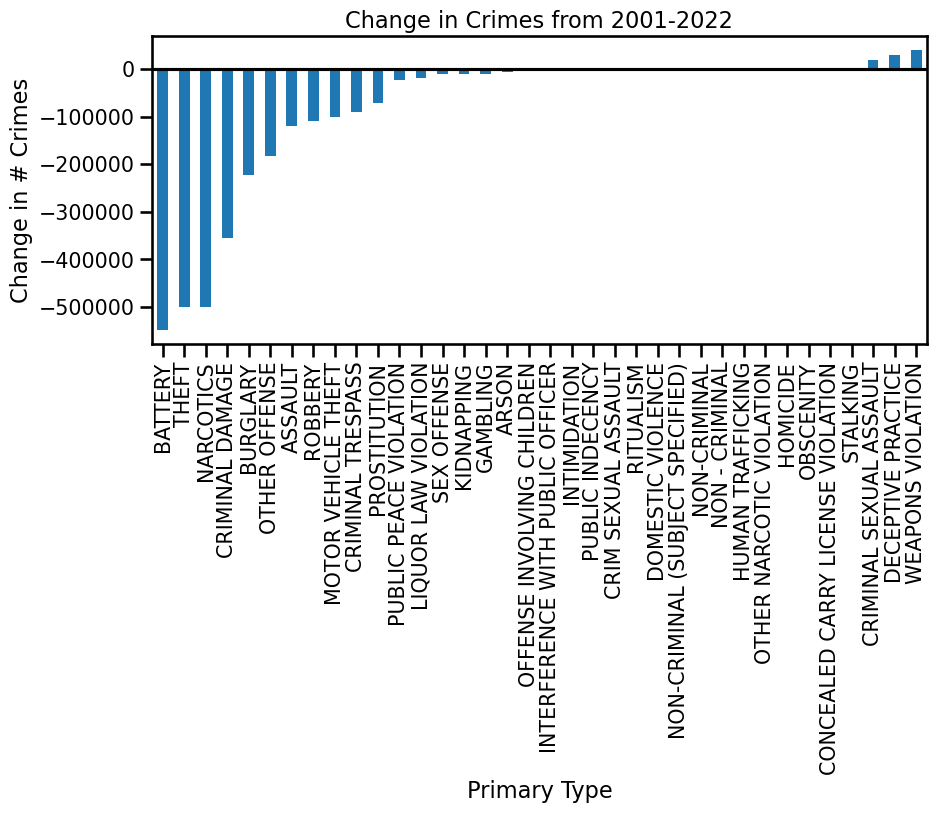

In [19]:
ax = delta_crime_yrs.sort_values().plot(kind='bar',figsize=(10,4),
                                       ylabel='Change in # Crimes',
                                       title='Change in Crimes from 2001-2022')
ax.axhline(0,color='k');

We can see here that the majority of crimes have decreased over time since 2001, with 3 crimes being the exception:

- Weapons Violation
- Deceptive Practice 
- Criminal Sexual Assault

## 4) Comparing Months:
What months have the most crime? What months have the least?
Are there any individual crimes that do not follow this pattern? If so, which crimes?

In [22]:
# Adding in MonthName and Month columns
df['Month'] = df.index.month
df['MonthName'] = df.index.month_name()
df.head()

,Primary Type,Description,District,Month,MonthName
Datetime,,,,,
2001-01-01 01:00:00,THEFT,$500 AND UNDER,19.0,1,January
2001-01-01 01:00:00,THEFT,$500 AND UNDER,3.0,1,January
2001-01-01 01:00:00,BATTERY,SIMPLE,25.0,1,January
2001-01-01 13:00:00,BATTERY,SIMPLE,8.0,1,January
2001-01-01 13:00:00,MOTOR VEHICLE THEFT,AUTOMOBILE,22.0,1,January


In [79]:
# Resampling data for monthly
crimes_by_month = df.groupby("Month")['Primary Type'].value_counts().sort_index()
crimes_by_month

Month  Primary Type                     
1      ARSON                                   963
       ASSAULT                               36518
       BATTERY                              104465
       BURGLARY                              33315
       CONCEALED CARRY LICENSE VIOLATION        82
                                             ...  
12     ROBBERY                               25749
       SEX OFFENSE                            1903
       STALKING                                332
       THEFT                                126633
       WEAPONS VIOLATION                      7401
Name: Primary Type, Length: 415, dtype: int64

In [81]:
# Convert to dataframe and reset_index()
plot_df = crimes_by_month.to_frame('# of Crimes').reset_index()
plot_df

,Month,Primary Type,# of Crimes
0,1,ARSON,963
1,1,ASSAULT,36518
2,1,BATTERY,104465
3,1,BURGLARY,33315
4,1,CONCEALED CARRY LICENSE VIOLATION,82
...,...,...,...
410,12,ROBBERY,25749
411,12,SEX OFFENSE,1903
412,12,STALKING,332
413,12,THEFT,126633


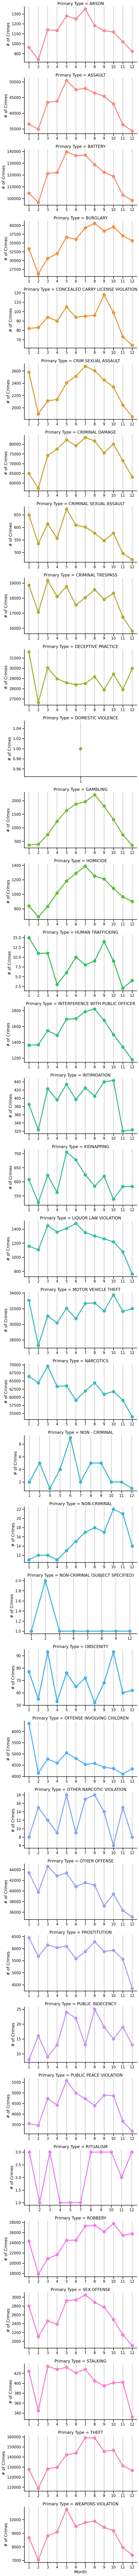

In [82]:
g = sns.catplot(data=plot_df, x='Month', y='# of Crimes',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=1,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];

### Calculating Change in crimes from 2001 - 2022

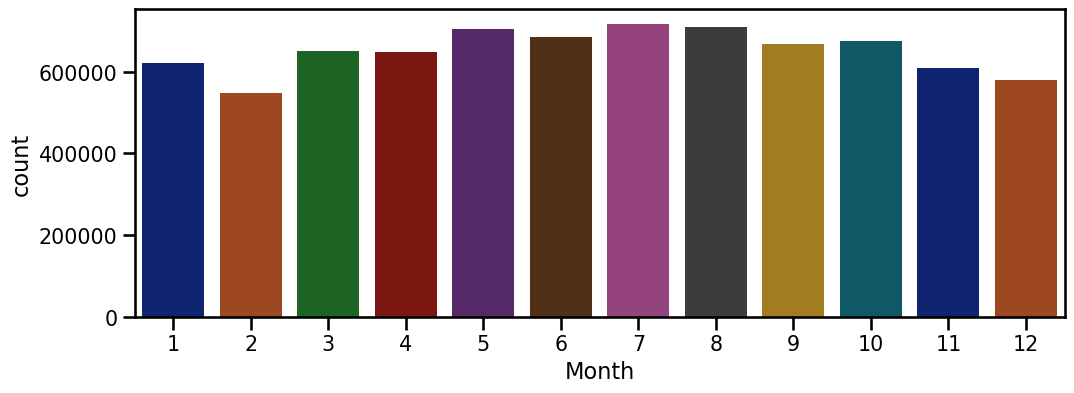

In [67]:
sns.countplot(data=df, x='Month',palette='dark');

In [68]:
# Saving lookup for number vs name
unique_months = df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

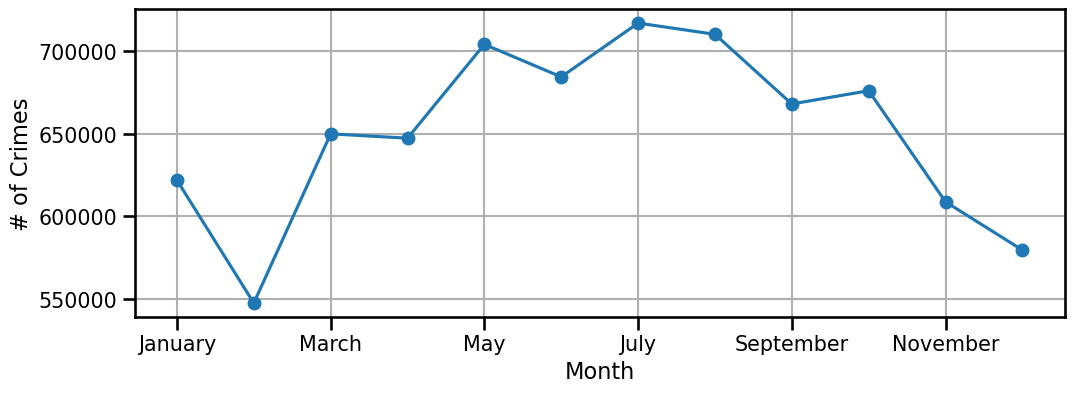

In [69]:
# Save month counts
month_counts = df['MonthName'].value_counts()[month_lookup.values()]
ax = month_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

In [72]:
df['Month'].value_counts()

7     717157
8     710354
5     704276
6     684544
10    676185
9     668165
3     650071
4     647430
1     621994
11    608883
12    579665
2     547554
Name: Month, dtype: int64

The Top 3 Months that have the most crime are:

1. July
2. August 
3. May

The 3 Months with the least amount of crime are:

1. February
2. December 
3. November

There are a few crimes that do not follow this same set up. Examples of them being:

- Public Indecency
- Ritualism
- Human Trafficking